In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#!/usr/bin/env python
import sys
import numpy             as np
# import healpy            as hp
import matplotlib.pyplot as plt
import halo2fluxmap      as h2fm

# Masses


Press-Schecter has

$$\frac{dn}{d \ln M} \propto M^{-1} $$

We cut off the masses at $10^9$ and $10^{15}$ to mimc a cosmological simulation.

Text(0.5,0,'$M [M_{\\odot}]$')

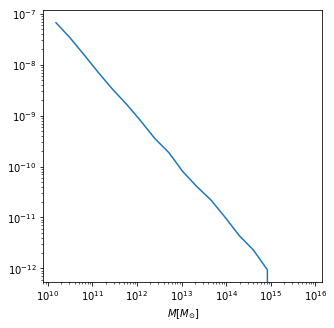

In [107]:
import powerlaw
# generates random variates of power law distribution

plt.figure(figsize=(5,5))
N = 100000
masses = powerlaw.Power_Law(xmin=1e9, parameters=[1.01]).generate_random(N)

masses = masses[masses > 1e9]
masses = masses[masses < 1e15]

vals, bins = np.histogram(masses, bins=np.logspace(10, 16, 20))
mids = (bins[1:] + bins[:-1]) / 2.0
norm = bins[1:] - bins[:-1]
plt.plot(mids, vals/norm, label='mass')
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$M [M_{\odot}]$')

In the Sehgal sims, the halo occupation number is defined as 
$$ N(M) = N_0 (M / M_0)^{\alpha}. $$
Both have $\alpha=0.1$ but `FR I` has $N_0 = 1$ and $M_0 = 4 \times 10^{13}$, `FR II` has $N_0 = 0.015$ and $M_0 = 3 \times 10^{15}$. Let's compute on average how many sources we'll have for every $10^6$ halos.

In [108]:
print('FR I', np.sum( (masses/4e13)**0.1 ) )
print('FR II', np.sum( 0.015 * (masses/3e15)**0.1 ) )

('FR I', 9419.216493723763)
('FR II', 91.74869836840874)


Next, we have a broken power law from Sehgal for the luminosity.

$$ p(L) = \begin{cases}  (L/L_b)^m & L > L_b  \\ (L/L_b)^n & \mathrm{otherwise}  \end{cases} $$

We have

### FR I
```
L_b = 1e24
m = -1.55
n = 0
```

### FR II
```
L_b = 1e27.5
m = -1.6
n = -0.65
```

In [59]:

def broken_power_law_sehgal(m_in, m, n, Lb):

    p0 = (1+m) * (1+n) / Lb / (m-n)
    
    def F_inv_lower(F_in):
        return (Lb**n * (1.0+n) * F_in / p0)**(1.0 / (1.0+n))
    def F_inv_upper(F_in):
        return (- Lb**m * (1+m) * (Lb * p0 * ( 1/(1.0+n) - 1/(1.0+m) ) - F_in) / p0 )**(1.0 / (1.0+m))
    Fb = Lb * p0 / (1+n)
    def F_inv(F_in):
        return np.piecewise(F_in, [F_in < Fb, F_in >= Fb], [F_inv_lower, F_inv_upper])
    
    unif_x = np.random.uniform(size=m_in.shape[0])
    return F_inv(unif_x)


Text(0.5,24,'$L$')

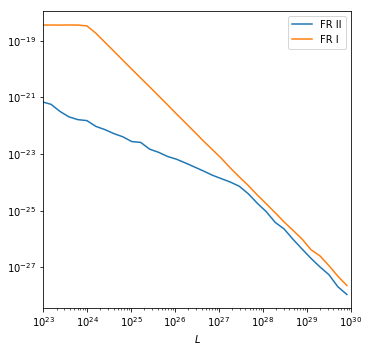

In [104]:
N_draws = int(1e6)


plt.figure(figsize=(5,5))

L_draw = broken_power_law_sehgal( np.ones(int(N_draws * 0.01)), m=-1.6, n=-0.65, Lb=10**27.5 )
vals, bins = np.histogram(L_draw, bins=np.logspace(20, 30, 50))
mids = (bins[1:] + bins[:-1]) / 2.0
norm = bins[1:] - bins[:-1]
plt.plot( mids, vals / norm, label='FR II' )

L_draw = broken_power_law_sehgal( np.ones(int(N_draws)), m=-1.55, n=0, Lb=10**24 )
vals, bins = np.histogram(L_draw, bins=np.logspace(20, 30, 50))
mids = (bins[1:] + bins[:-1]) / 2.0
norm = bins[1:] - bins[:-1]
plt.plot( mids, vals / norm, label='FR I' )


plt.xlim(1e23, 1e30)
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$L$')